# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import imageio.v2 as imageio
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(100)
import random as rn
rn.seed(100)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(100)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
!gdown "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t
To: /content/Project_data.zip
100% 1.71G/1.71G [00:20<00:00, 84.8MB/s]


In [4]:
!unzip Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [5]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())




## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size, img_h, img_w, sequence_index):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = sequence_index
    num_batches = len(folder_list)//batch_size #number of batches num of folders/batches can be made ignoring remainder
    x = len(img_idx)
    y = img_h
    z = img_w

    while True:
        t = np.random.permutation(folder_list)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image, [img_h,img_w])


                    #normalize by channel
                    batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],2.5))/ (np.percentile(image[:, : , 0],97.5) - np.percentile(image[:, : , 0],2.5))
                    batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],2.5))/ (np.percentile(image[:, : , 1],97.5) - np.percentile(image[:, : , 1],2.5))
                    batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],2.5))/ (np.percentile(image[:, : , 2],97.5) - np.percentile(image[:, : , 2],2.5))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


        # write the code for the remaining data points which are left after full batches
        if len(folder_list) != batch_size*num_batches:
            num_remaining_folders = len(folder_list) - (batch_size*num_batches) #total length of folder list minus complete batch length
            batch_data = np.zeros((num_remaining_folders,x,y,z,3))
            batch_labels = np.zeros((num_remaining_folders,5))

            for folder in range(num_remaining_folders): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image, [img_h,img_w])


                    #normalize by channel
                    batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],2.5))/ (np.percentile(image[:, : , 0],97.5) - np.percentile(image[:, : , 0],2.5))
                    batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],2.5))/ (np.percentile(image[:, : , 1],97.5) - np.percentile(image[:, : , 1],2.5))
                    batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],2.5))/ (np.percentile(image[:, : , 2],97.5) - np.percentile(image[:, : , 2],2.5))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.date.today()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers,Input

## 3D CONVOLUTION ARCHITECTURES EXPERIMENTS


Constants for all 3d Conv

- epoachs = 25
- optimiser = SGD(lr=0.01, momentum=0.5)
- max pooling = (3,3,3)


### Batch Size

#### Large Batch Size of 63 - Model 1

Constants
- sequence length = 30
- img size = 120,120,3

In [10]:
batch_size=63

model1 = Sequential()

model1.add(Conv3D(16, (3,3,3), input_shape = (30,120,120,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(3,3,3)))


model1.add(Conv3D(32, (3,3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(3,3,3)))
model1.add(Dropout(0.3))

model1.add(MaxPooling3D(pool_size=(3,3,3)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))


model1.add(Dense(5))
model1.add(Activation('softmax'))



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 40, 40, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 40, 40, 32)   1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [9]:
if not os.path.exists("models"):
    os.mkdir("models")

os.chdir("/content/models")

In [14]:
model_name = 'model_1_batch63_' + str(curr_dt_time).replace('-','') ## using datetime.date.today()

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name+ "/" + model_name + '.h5'
#model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
model_1 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/Project_data/train ; batch size = 63
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 3.4770 - categorical_accuracy: 0.2443 Source path =  /content/Project_data/val ; batch size = 63

Epoch 1: val_loss improved from inf to 1.67288, saving model to model_1_batch63_20230729/model_1_batch63_20230729.h5
11/11 [==============================] - 232s 22s/step - loss: 3.4770 - categorical_accuracy: 0.2443 - val_loss: 1.6729 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.6111 - categorical_accuracy: 0.3198 
Epoch 2: val_loss improved from 1.67288 to 1.66324, saving model to model_1_batch63_20230729/model_1_batch63_20230729.h5
11/11 [==============================] - 221s 22s/step - loss: 1.6111 - categorical_accuracy: 0.3198 - val_loss: 1.6632 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 1.4323 - categorical_acc

In [10]:
import matplotlib.pyplot as plt

def plot_acc(model, epochs):
    acc = model.history['categorical_accuracy']
    val_acc = model.history['val_categorical_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

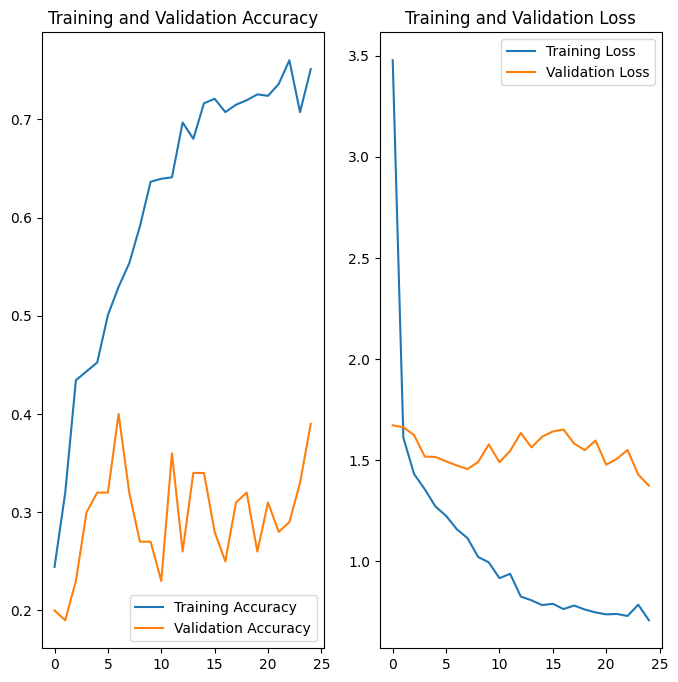

In [18]:
plot_acc(model_1,num_epochs)

#### **Observations**

Clear overfitting, model does not learn.

#### Small Batch Size of 7 - Model 2

Constants
- sequence length = 30
- img size = 120,120,3


In [19]:
batch_size = 7

model2 = Sequential()

model2.add(Conv3D(16, (3,3,3), input_shape = (30,120,120,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(3,3,3)))


model2.add(Conv3D(32, (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(3,3,3)))
model2.add(Dropout(0.3))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))


model2.add(Dense(5))
model2.add(Activation('softmax'))

In [20]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_2 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 40, 40, 16)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_3 (Batc  (None, 10, 40, 40, 32)  

In [21]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [22]:
model_name = 'model_2_batch7_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
model_2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 5.0734 - categorical_accuracy: 0.2624Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.68671, saving model to model_2_batch7_20230729/model_2_batch7_20230729.h5
95/95 [==============================] - 226s 2s/step - loss: 5.0734 - categorical_accuracy: 0.2624 - val_loss: 1.6867 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.5062 - categorical_accuracy: 0.3107
Epoch 2: val_loss improved from 1.68671 to 1.47058, saving model to model_2_batch7_20230729/model_2_batch7_20230729.h5
95/95 [==============================] - 223s 2s/step - loss: 1.5062 - categorical_accuracy: 0.3107 - val_loss: 1.4706 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.4700 - categorical_accuracy: 0.3

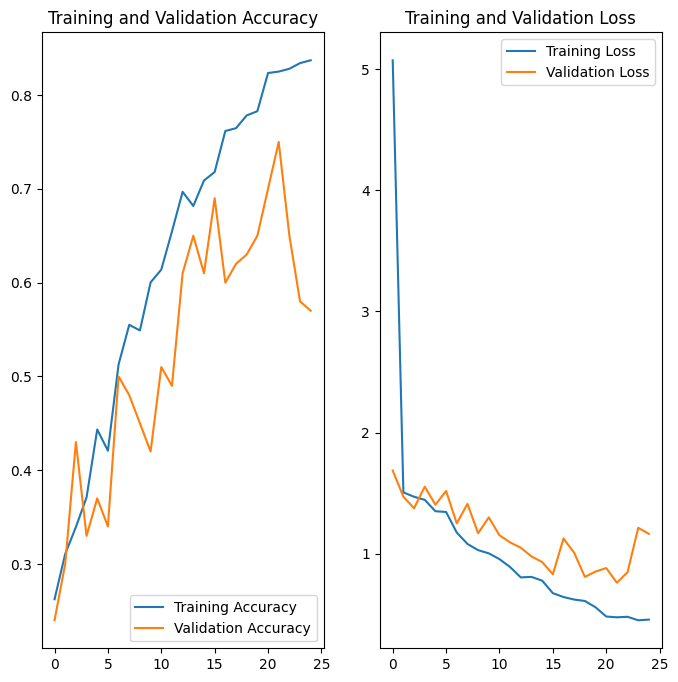

In [25]:
plot_acc(model_2,num_epochs)

#### Observations
overfitting still occurs but model learns a lot better with smaller batch size. Each step is shorter but the overall time per epoch is essentially the same

### Number of Sequences

#### Sequence length of 15 - Model 3

Constants
- batch_size = 7
- img size = 120,120,3

In [40]:
batch_size = 7

model3 = Sequential()

model3.add(Conv3D(16, (3,3,3), input_shape = (15,120,120,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3,3,3)))


model3.add(Conv3D(32, (3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(3,3,3)))
model3.add(Dropout(0.3))

model3.add(Flatten())

model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))


model3.add(Dense(5))
model3.add(Activation('softmax'))

In [41]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_8 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 5, 40, 40, 32)     13856     
                                                                 
 batch_normalization_9 (Batc  (None, 5, 40, 40, 32)   

In [42]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [43]:
model_name = 'model_3_seq15_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [44]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [45]:
model_3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 2.4902 - categorical_accuracy: 0.3213Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.31342, saving model to model_3_seq15_20230729/model_3_seq15_20230729.h5
95/95 [==============================] - 113s 1s/step - loss: 2.4902 - categorical_accuracy: 0.3213 - val_loss: 1.3134 - val_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.2361 - categorical_accuracy: 0.4842
Epoch 2: val_loss improved from 1.31342 to 1.16513, saving model to model_3_seq15_20230729/model_3_seq15_20230729.h5
95/95 [==============================] - 111s 1s/step - loss: 1.2361 - categorical_accuracy: 0.4842 - val_loss: 1.1651 - val_categorical_accuracy: 0.5200 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.0758 - categorical_accuracy: 0.5747


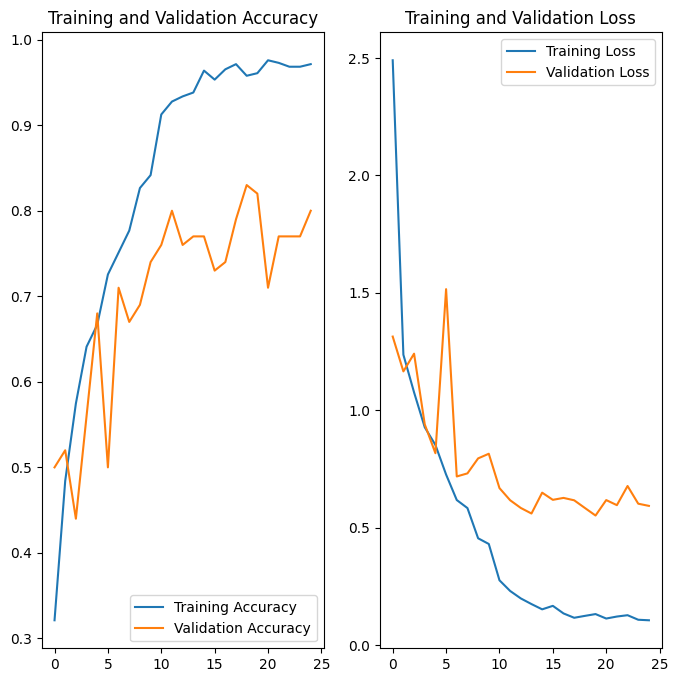

In [46]:
plot_acc(model_3,num_epochs)

#### Observations

faster training due to fewer images per step

### Resizing Images - Model 4

#### IMG SIZE 160,160

Constants
- sequence length = 15
- batch size = 7


In [47]:
batch_size = 7

model4 = Sequential()

model4.add(Conv3D(16, (3,3,3), input_shape = (15,160,160,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3,3,3)))


model4.add(Conv3D(32, (3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3,3,3)))
model4.add(Dropout(0.3))

model4.add(Flatten())

model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))


model4.add(Dense(5))
model4.add(Activation('softmax'))

In [48]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 15, 160, 160, 16)  1312      
                                                                 
 batch_normalization_10 (Bat  (None, 15, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 15, 160, 160, 16)  0         
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 5, 53, 53, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 5, 53, 53, 32)     13856     
                                                                 
 batch_normalization_11 (Bat  (None, 5, 53, 53, 32)   

In [49]:
img_h=160
img_w = 160
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [50]:
model_name = 'model_4_img160x160_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [52]:
model_4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 2.5145 - categorical_accuracy: 0.3107Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.38628, saving model to model_4_img160x160_20230729/model_4_img160x160_20230729.h5
95/95 [==============================] - 146s 2s/step - loss: 2.5145 - categorical_accuracy: 0.3107 - val_loss: 1.3863 - val_categorical_accuracy: 0.4300 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.1818 - categorical_accuracy: 0.4902
Epoch 2: val_loss improved from 1.38628 to 1.14507, saving model to model_4_img160x160_20230729/model_4_img160x160_20230729.h5
95/95 [==============================] - 145s 2s/step - loss: 1.1818 - categorical_accuracy: 0.4902 - val_loss: 1.1451 - val_categorical_accuracy: 0.5200 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 0.9823 - categoric

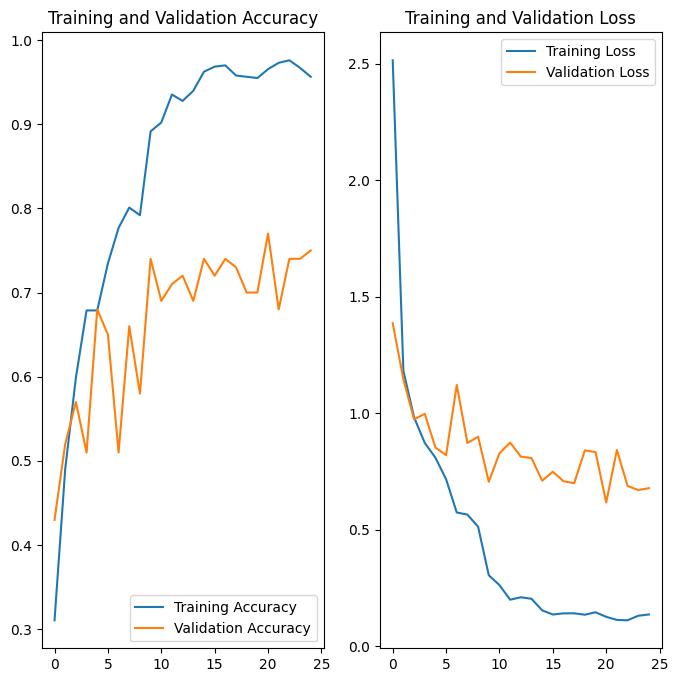

In [53]:
plot_acc(model_4,num_epochs)

#### **Observations**

worse overfitting than 120x120 with similar cross entropy loss.

### Increasing Conv Depth - Model 5

#### Conv Layers = 3

Constants:
- img_size = 120,120
- sequence length = 15
- batch size = 7

In [61]:
batch_size = 7

model5 = Sequential()

model5.add(Conv3D(16, (3,3,3), input_shape = (15,120,120,3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))


model5.add(Conv3D(32, (3,3,3),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))
model5.add(Dropout(0.3))

model5.add(Conv3D(64, (3,3,3),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Flatten())

model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.5))


model5.add(Dense(5))
model5.add(Activation('softmax'))

In [62]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_18 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_19 (Bat  (None, 7, 60, 60, 32)   

In [63]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [64]:
model_name = 'model_5_convlayers3_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [66]:
model_5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 3.4022 - categorical_accuracy: 0.2624Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.46732, saving model to model_5_convlayers3_20230729/model_5_convlayers3_20230729.h5
95/95 [==============================] - 113s 1s/step - loss: 3.4022 - categorical_accuracy: 0.2624 - val_loss: 1.4673 - val_categorical_accuracy: 0.3500 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.4356 - categorical_accuracy: 0.3710
Epoch 2: val_loss did not improve from 1.46732
95/95 [==============================] - 112s 1s/step - loss: 1.4356 - categorical_accuracy: 0.3710 - val_loss: 1.5583 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.3750 - categorical_accuracy: 0.4087
Epoch 3: val_loss did not improve from 1.46732
95/95 [====

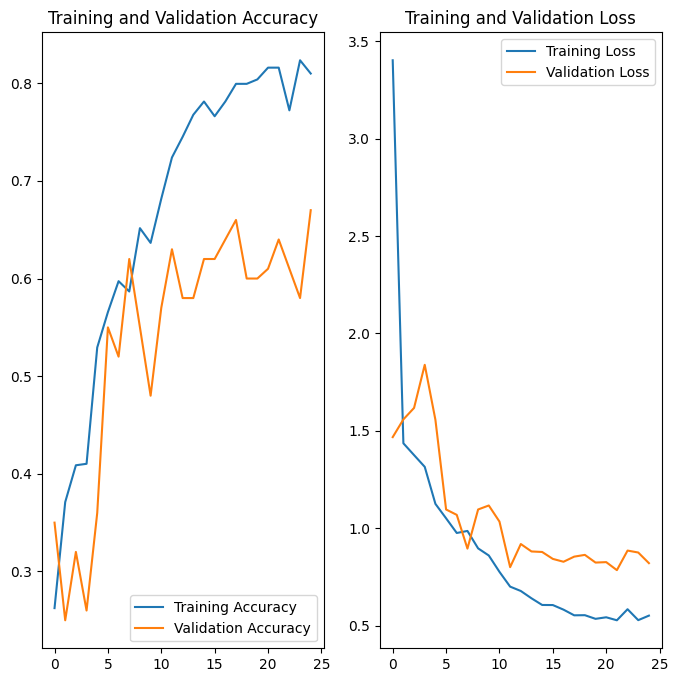

In [67]:
plot_acc(model_5,num_epochs)

#### **Observations**


### Comparing Pool Size - Model 6

#### Pool Size 2,2,2

Constants
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2

In [68]:
batch_size = 7

model6 = Sequential()

model6.add(Conv3D(16, (3,3,3), input_shape = (15,120,120,3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))


model6.add(Conv3D(32, (3,3,3),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2,2,2)))
model6.add(Dropout(0.3))

model6.add(Flatten())

model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.5))


model6.add(Dense(5))
model6.add(Activation('softmax'))

In [69]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_21 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_22 (Bat  (None, 7, 60, 60, 32)   

In [70]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [71]:
model_name = 'model_6_pool222_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [72]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [73]:
model_6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 7.4168 - categorical_accuracy: 0.2670Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.50711, saving model to model_6_pool222_20230729/model_6_pool222_20230729.h5
95/95 [==============================] - 113s 1s/step - loss: 7.4168 - categorical_accuracy: 0.2670 - val_loss: 1.5071 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.2686 - categorical_accuracy: 0.4751
Epoch 2: val_loss improved from 1.50711 to 1.22658, saving model to model_6_pool222_20230729/model_6_pool222_20230729.h5
95/95 [==============================] - 113s 1s/step - loss: 1.2686 - categorical_accuracy: 0.4751 - val_loss: 1.2266 - val_categorical_accuracy: 0.4600 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.0238 - categorical_accuracy:

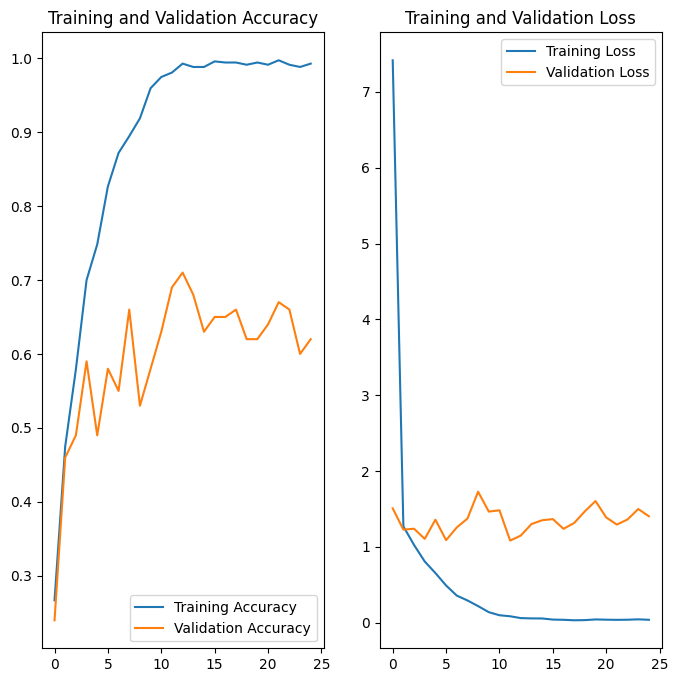

In [74]:
plot_acc(model_6,num_epochs)

#### **Observations**


### Using LeakyReLU activation - Model 7

#### Leaky ReLU aplha of 0.01

Constants
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3,3

In [75]:
from keras.layers import LeakyReLU


LeakyReLU = LeakyReLU(alpha=0.01)

batch_size = 7

model7 = Sequential()

model7.add(Conv3D(16, (3,3,3), input_shape = (15,120,120,3), padding='same'))
model7.add(BatchNormalization())
model7.add(Activation(LeakyReLU))
model7.add(MaxPooling3D(pool_size=(3,3,3)))


model7.add(Conv3D(32, (3,3,3),padding='same'))
model7.add(BatchNormalization())
model7.add(Activation(LeakyReLU))
model7.add(MaxPooling3D(pool_size=(3,3,3)))
model7.add(Dropout(0.3))

model7.add(Flatten())

model7.add(Dense(512, activation=LeakyReLU))
model7.add(Dropout(0.5))


model7.add(Dense(5))
model7.add(Activation('softmax'))

In [76]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.5)
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_23 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 batch_normalization_23 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 5, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_24 (Conv3D)          (None, 5, 40, 40, 32)     13856     
                                                                 
 batch_normalization_24 (Bat  (None, 5, 40, 40, 32)  

In [77]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [78]:
model_name = 'model_7_leakyrelu_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [79]:
model_7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 2.5760 - categorical_accuracy: 0.3228Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.44104, saving model to model_7_leakyrelu_20230729/model_7_leakyrelu_20230729.h5
95/95 [==============================] - 112s 1s/step - loss: 2.5760 - categorical_accuracy: 0.3228 - val_loss: 1.4410 - val_categorical_accuracy: 0.3300 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.3331 - categorical_accuracy: 0.4163
Epoch 2: val_loss improved from 1.44104 to 1.19279, saving model to model_7_leakyrelu_20230729/model_7_leakyrelu_20230729.h5
95/95 [==============================] - 111s 1s/step - loss: 1.3331 - categorical_accuracy: 0.4163 - val_loss: 1.1928 - val_categorical_accuracy: 0.5200 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.2377 - categorical_a

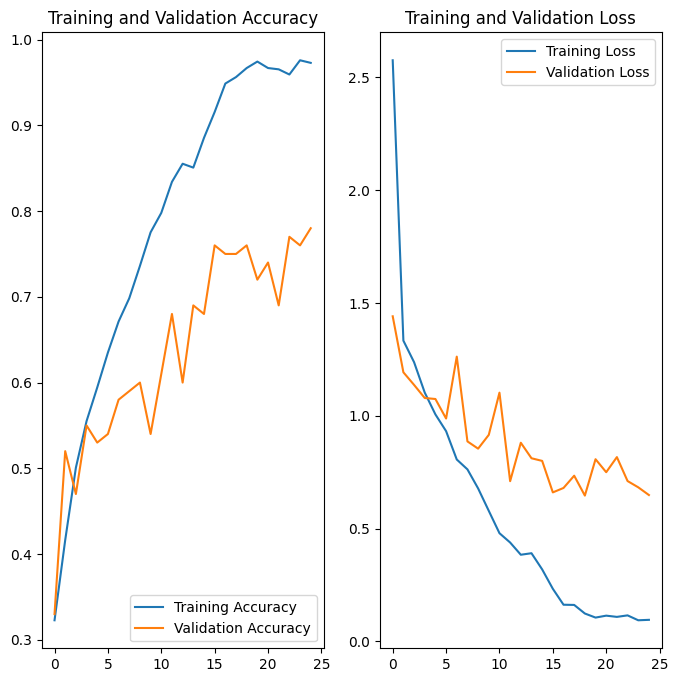

In [80]:
plot_acc(model_7,num_epochs)

#### **Observations**

## ConvRNN Architectures



#### ConvRNN Model 1 - LSTM


Constants

- LSTM Cells = 32
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3


In [18]:
batch_size = 7

model8 = Sequential()

model8.add(Input(shape=(15,120,120,3)))

model8.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3,3))))

model8.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3,3))))
model8.add(Dropout(0.3))

model8.add(TimeDistributed(Flatten()))

model8.add(LSTM(32))
model8.add(Dropout(0.3))



model8.add(Dense(5, activation='softmax'))


In [19]:
optimiser = optimizers.SGD(learning_rate = 0.01, momentum=0.5)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 15, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 40, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 40, 40, 32)  

In [20]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [21]:
model_name = 'lstm_base_32_cells_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
model_8 = model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 1.5926 - categorical_accuracy: 0.2670Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.55694, saving model to lstm_base_32_cells_20230730/lstm_base_32_cells_20230730.h5
95/95 [==============================] - 116s 1s/step - loss: 1.5926 - categorical_accuracy: 0.2670 - val_loss: 1.5569 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.3329 - categorical_accuracy: 0.4284
Epoch 2: val_loss improved from 1.55694 to 1.55297, saving model to lstm_base_32_cells_20230730/lstm_base_32_cells_20230730.h5
95/95 [==============================] - 114s 1s/step - loss: 1.3329 - categorical_accuracy: 0.4284 - val_loss: 1.5530 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.1367 - categoric

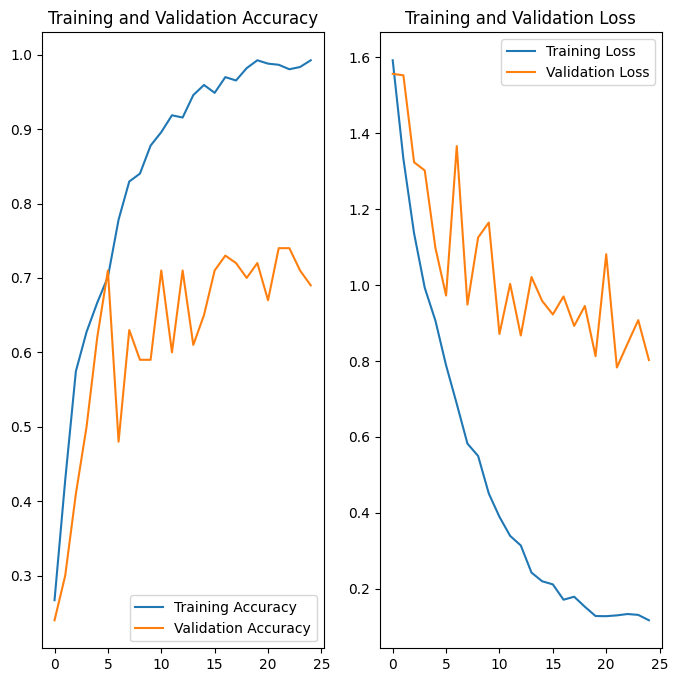

In [24]:
plot_acc(model_8,num_epochs)

#### **Observations**

rapid overfitting but also rapid increase in validation accuracy at first but then plateau.

### ConvRNN Model 2 - GRU

#### GRU Cells

Constants
- GRU Cells = 32
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3




In [25]:
batch_size = 7

model9 = Sequential()

model9.add(Input(shape=(15,120,120,3)))

model9.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((3,3))))

model9.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((3,3))))
model9.add(Dropout(0.3))

model9.add(TimeDistributed(Flatten()))

model9.add(GRU(32))
model9.add(Dropout(0.3))



model9.add(Dense(5, activation='softmax'))

In [26]:
optimiser = optimizers.SGD(learning_rate = 0.01, momentum=0.5)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 40, 40, 32)  

In [27]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [28]:
model_name = 'gru_base_32_cells_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
model_9 = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 1.6889 - categorical_accuracy: 0.2881Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.60639, saving model to gru_base_32_cells_20230730/gru_base_32_cells_20230730.h5
95/95 [==============================] - 114s 1s/step - loss: 1.6889 - categorical_accuracy: 0.2881 - val_loss: 1.6064 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.4433 - categorical_accuracy: 0.3650
Epoch 2: val_loss improved from 1.60639 to 1.38044, saving model to gru_base_32_cells_20230730/gru_base_32_cells_20230730.h5
95/95 [==============================] - 110s 1s/step - loss: 1.4433 - categorical_accuracy: 0.3650 - val_loss: 1.3804 - val_categorical_accuracy: 0.4800 - lr: 0.0100
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.2763 - categorical_a

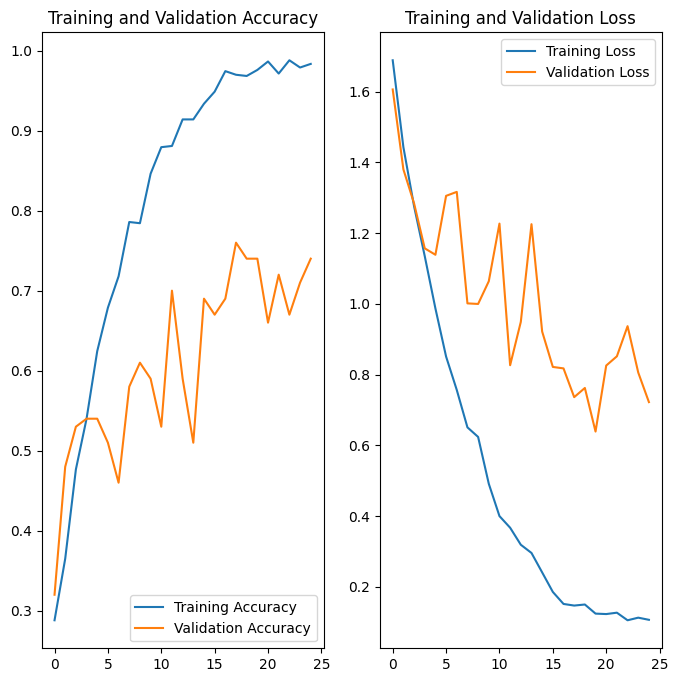

In [31]:
plot_acc(model_9,num_epochs)

#### **Observations**


### ConvRNN Model 3 - Optimiser Variation

#### Model 10 - Adam Optimiser
Constants
- GRU Cells = 32
- img size = 120,120
- batch size = 7
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3

In [32]:
batch_size = 7

model10 = Sequential()

model10.add(Input(shape=(15,120,120,3)))

model10.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D((3,3))))

model10.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D((3,3))))
model10.add(Dropout(0.3))

model10.add(TimeDistributed(Flatten()))

model10.add(GRU(32))
model10.add(Dropout(0.3))



model10.add(Dense(5, activation='softmax'))

In [33]:
optimiser = optimizers.Adam()
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 15, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 15, 40, 40, 32)  

In [34]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [35]:
model_name = 'gru_base_Adam_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
model_10 = model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 7
Epoch 1/25
95/95 [==============================] - ETA: 0s - loss: 1.7504 - categorical_accuracy: 0.2745Source path =  /content/Project_data/val ; batch size = 7

Epoch 1: val_loss improved from inf to 1.59107, saving model to gru_base_Adam_20230730/gru_base_Adam_20230730.h5
95/95 [==============================] - 115s 1s/step - loss: 1.7504 - categorical_accuracy: 0.2745 - val_loss: 1.5911 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
95/95 [==============================] - ETA: 0s - loss: 1.5715 - categorical_accuracy: 0.3499
Epoch 2: val_loss did not improve from 1.59107
95/95 [==============================] - 112s 1s/step - loss: 1.5715 - categorical_accuracy: 0.3499 - val_loss: 1.8391 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/25
95/95 [==============================] - ETA: 0s - loss: 1.4524 - categorical_accuracy: 0.3816
Epoch 3: val_loss did not improve from 1.59107
95/95 [================

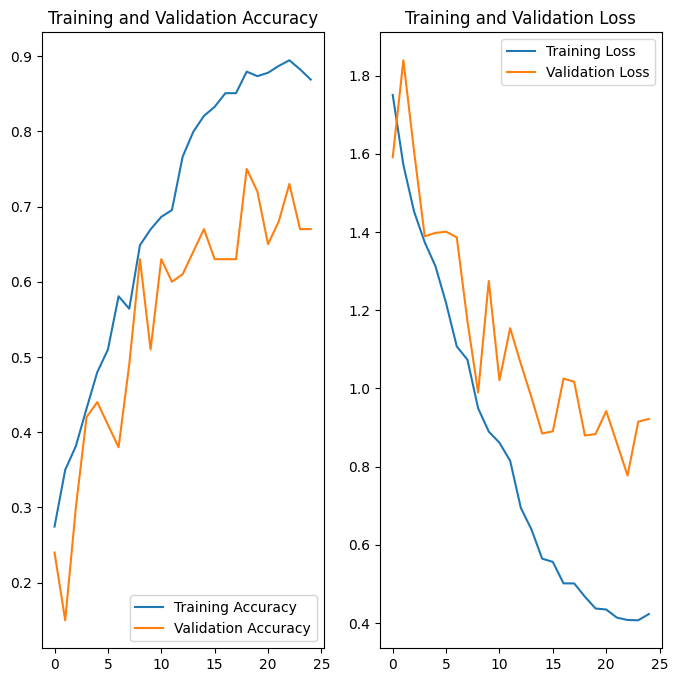

In [38]:
plot_acc(model_10,num_epochs)

#### **Observations**

model overfit less with similar accuracy but higher loss values. perhaps longer training time is needed

### ConvRNN Model 4 - lower batch size


#### Model 11 - Batch size = 5

Constants
- GRU Cells = 32
- img size = 120,120
- sequence length = 15
- Conv depth = 2
- Max Pooling = 3,3

In [39]:
batch_size = 5

model11 = Sequential()

model11.add(Input(shape=(15,120,120,3)))

model11.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model11.add(TimeDistributed(BatchNormalization()))
model11.add(TimeDistributed(MaxPooling2D((3,3))))

model11.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model11.add(TimeDistributed(BatchNormalization()))
model11.add(TimeDistributed(MaxPooling2D((3,3))))
model11.add(Dropout(0.3))

model11.add(TimeDistributed(Flatten()))

model11.add(GRU(32))
model11.add(Dropout(0.3))



model11.add(Dense(5, activation='softmax'))

In [40]:
optimiser = optimizers.Adam()
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model11.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 15, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 15, 40, 40, 32)  

In [41]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [42]:
model_name = 'gru_base_batch5_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [43]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [44]:
model_11 = model11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.8084 - categorical_accuracy: 0.2398Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 2.01163, saving model to gru_base_batch5_20230730/gru_base_batch5_20230730.h5
133/133 [==============================] - 118s 876ms/step - loss: 1.8084 - categorical_accuracy: 0.2398 - val_loss: 2.0116 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.5575 - categorical_accuracy: 0.3137
Epoch 2: val_loss improved from 2.01163 to 1.81475, saving model to gru_base_batch5_20230730/gru_base_batch5_20230730.h5
133/133 [==============================] - 116s 879ms/step - loss: 1.5575 - categorical_accuracy: 0.3137 - val_loss: 1.8147 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.5491 - categ

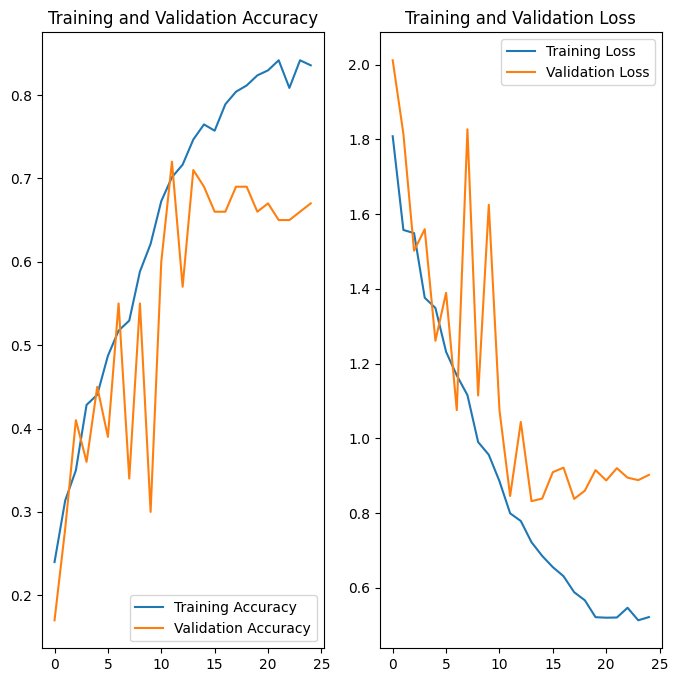

In [45]:
plot_acc(model_11,num_epochs)

### ConvRNN Model 5 - More cells

#### Model 12 GRU cells = 64

Constants
- img size = 120,120
- batch size = 5
- sequence length = 15
- Conv depth = 2

In [46]:
batch_size = 5

model12 = Sequential()

model12.add(Input(shape=(15,120,120,3)))

model12.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model12.add(TimeDistributed(BatchNormalization()))
model12.add(TimeDistributed(MaxPooling2D((3,3))))

model12.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model12.add(TimeDistributed(BatchNormalization()))
model12.add(TimeDistributed(MaxPooling2D((3,3))))
model12.add(Dropout(0.3))

model12.add(TimeDistributed(Flatten()))

model12.add(GRU(64))
model12.add(Dropout(0.3))



model12.add(Dense(5, activation='softmax'))

In [47]:
optimiser = optimizers.Adam()
model12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model12.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 15, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 15, 40, 40, 32)  

In [48]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)


In [49]:
model_name = 'gru_base_gru64_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [50]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [51]:
model_12 = model12.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.7554 - categorical_accuracy: 0.2760Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.92798, saving model to gru_base_gru64_20230730/gru_base_gru64_20230730.h5
133/133 [==============================] - 120s 887ms/step - loss: 1.7554 - categorical_accuracy: 0.2760 - val_loss: 1.9280 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.5080 - categorical_accuracy: 0.3575
Epoch 2: val_loss improved from 1.92798 to 1.83152, saving model to gru_base_gru64_20230730/gru_base_gru64_20230730.h5
133/133 [==============================] - 125s 947ms/step - loss: 1.5080 - categorical_accuracy: 0.3575 - val_loss: 1.8315 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.4196 - categoric

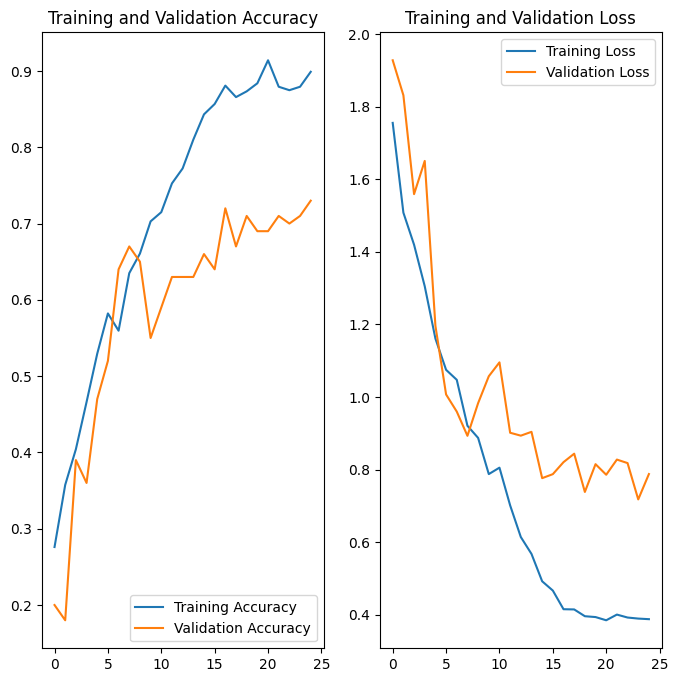

In [52]:
plot_acc(model_12,num_epochs)

#### **Observations**

More GRU cells leads to more overfitting and no improvement vs fewer in terms of validation metrics

### ConvRNN Model 6 - pool size

#### Model 13 - pool size = 2,2, stride 2

Constants
- img size = 120,120
- batch size = 5
- sequence length = 15
- Conv depth = 2
- GRU cells = 32

In [53]:
batch_size = 5

model13 = Sequential()

model13.add(Input(shape=(15,120,120,3)))

model13.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model13.add(TimeDistributed(BatchNormalization()))
model13.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)))

model13.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model13.add(TimeDistributed(BatchNormalization()))
model13.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2)))
model13.add(Dropout(0.3))

model13.add(TimeDistributed(Flatten()))

model13.add(GRU(32))
model13.add(Dropout(0.3))



model13.add(Dense(5, activation='softmax'))

In [54]:
optimiser = optimizers.Adam()
model13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model13.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 15, 60, 60, 32)  

In [55]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)


In [56]:
model_name = 'gru_base_pool22_s2_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [57]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [58]:
model_13 = model13.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.6764 - categorical_accuracy: 0.2971Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.58631, saving model to gru_base_pool22_s2_20230730/gru_base_pool22_s2_20230730.h5
133/133 [==============================] - 122s 900ms/step - loss: 1.6764 - categorical_accuracy: 0.2971 - val_loss: 1.5863 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.5111 - categorical_accuracy: 0.3439
Epoch 2: val_loss did not improve from 1.58631
133/133 [==============================] - 118s 892ms/step - loss: 1.5111 - categorical_accuracy: 0.3439 - val_loss: 1.5912 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.4768 - categorical_accuracy: 0.3771
Epoch 3: val_loss improved from 1.58631 to 1

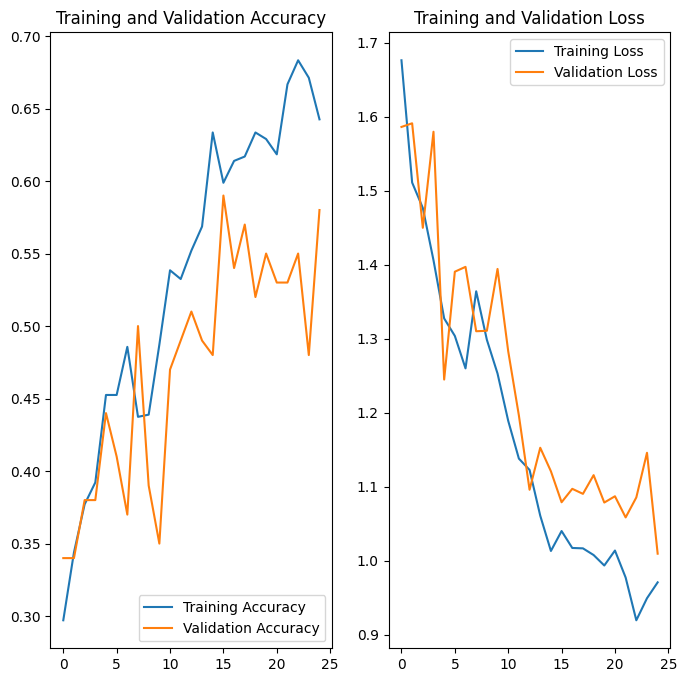

In [59]:
plot_acc(model_13,num_epochs)

#### **Observations**

seems like the most stable model so far. will increase depth and run again

### ConvRNN Model 7 - More Conv



#### Model 14 - Another Conv Layer

Constants
- img size = 120,120
- batch size = 5
- sequence length = 15
- GRU cells = 32
- pool size = (2,2) s=2



In [60]:
batch_size = 5

model14 = Sequential()

model14.add(Input(shape=(15,120,120,3)))

model14.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
model14.add(TimeDistributed(BatchNormalization()))
model14.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)))

model14.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model14.add(TimeDistributed(BatchNormalization()))
model14.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2)))
model14.add(Dropout(0.3))

model14.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model14.add(TimeDistributed(BatchNormalization()))
model14.add(TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2)))

model14.add(TimeDistributed(Flatten()))

model14.add(GRU(32))
model14.add(Dropout(0.3))



model14.add(Dense(5, activation='softmax'))

In [61]:
optimiser = optimizers.Adam()
model14.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model14.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_49 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 15, 60, 60, 32)  

In [62]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [63]:
model_name = 'gru_base_deep_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [64]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [65]:
model_14 = model14.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.7368 - categorical_accuracy: 0.2112Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 1.77981, saving model to gru_base_deep_20230730/gru_base_deep_20230730.h5
133/133 [==============================] - 127s 940ms/step - loss: 1.7368 - categorical_accuracy: 0.2112 - val_loss: 1.7798 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.6427 - categorical_accuracy: 0.2730
Epoch 2: val_loss did not improve from 1.77981
133/133 [==============================] - 120s 905ms/step - loss: 1.6427 - categorical_accuracy: 0.2730 - val_loss: 1.8664 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.6159 - categorical_accuracy: 0.2941
Epoch 3: val_loss did not improve from 1.77981
133/133

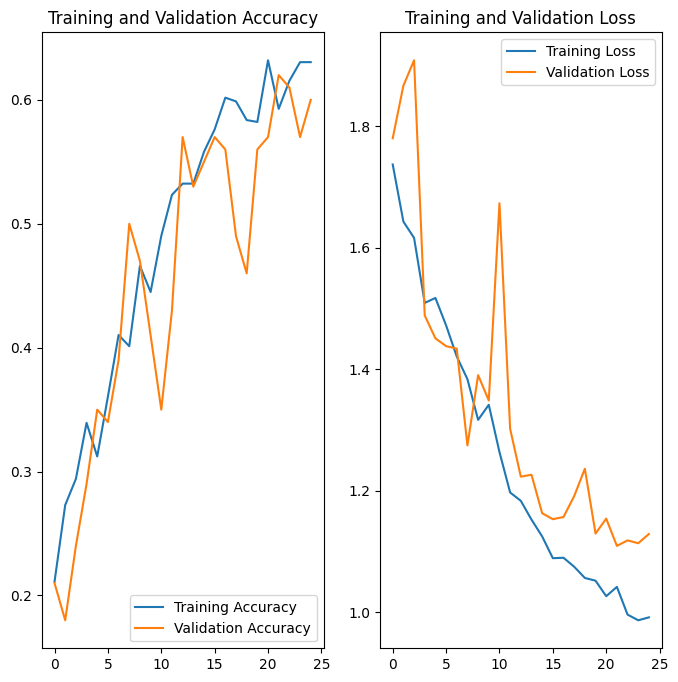

In [66]:
plot_acc(model_14,num_epochs)

#### **Observations**
Similar stable performance to the previous model but this time accuracy and loss increased continuously.

### ConvRNN Model 8 - More FC



#### Model 15 -
- rnn(32) -> rnn(64)
-num_epochs(25) -> 40
-model15.add(TimeDistributed(Dense(256, activation='relu'))) #added this layer
model15.add(TimeDistributed(BatchNormalization())) ##added

Constants
- img size = 120,120
- batch size = 5
- sequence length = 15
- GRU cells = 32
- pool size = (2,2) s=2
- conv layer = 3



In [74]:
## residual
from keras.layers import Add


batch_size = 5
num_epochs=40 ## updated from 25

model15 = Sequential()

input = Input(shape=(15,120,120,3))

layer1 = TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'))(input) #main
skip1 = TimeDistributed(Conv2D(16, (1, 1), padding='same', activation='relu'))(input) #skip
layer1 = TimeDistributed(BatchNormalization())(layer1)
skip = Add()([skip1,layer1])
layer1 = TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2))(layer1)

layer2 = TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu'))(layer1)
layer2 = TimeDistributed(BatchNormalization())(layer2)
layer2 = TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2))(layer2)
layer2 = Dropout(0.3)(layer2)

layer3 = TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu'))(layer2)
skip2 = TimeDistributed(Conv2D(64, (1, 1), padding='same', activation='relu'))(layer2) #skip
layer3 = TimeDistributed(BatchNormalization())(layer3)
layer3 = Add()([skip2,layer3])
layer3 = TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2))(layer3)

layer4 = TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu'))(layer3)
layer4 = TimeDistributed(BatchNormalization())(layer4)
layer4 = TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2))(layer4)
layer4 = Dropout(0.3)(layer4)

layer5 = TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu'))(layer4)
layer5 = TimeDistributed(BatchNormalization())(layer5)
layer5 = TimeDistributed(MaxPooling2D(pool_size=(2,2),strides=2))(layer5)
layer5 = Dropout(0.3)(layer5)

flatten = TimeDistributed(Flatten())(layer5)

gru = GRU(64,)(flatten)
gru = Dropout(0.5)(gru)

output = Dense(5, activation='softmax')(gru)

model15=Model(inputs=input, outputs=output)

In [75]:
optimiser = optimizers.Adam()
model15.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model15.summary())

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 15, 120, 12  0           []                               
                                0, 3)]                                                            
                                                                                                  
 time_distributed_202 (TimeDist  (None, 15, 120, 120  448        ['input_12[0][0]']               
 ributed)                       , 16)                                                             
                                                                                                  
 time_distributed_204 (TimeDist  (None, 15, 120, 120  64         ['time_distributed_202[0][0]']   
 ributed)                       , 16)                                                      

In [76]:
img_h=120
img_w = 120
sequence_index=[i for i in range(0,30,2)]

train_generator = generator(train_path, train_doc, batch_size, img_h, img_w, sequence_index)
val_generator = generator(val_path, val_doc, batch_size, img_h, img_w, sequence_index)

In [79]:
model_name = 'gru_base_fc_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.2,
                      patience=3,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [80]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [81]:
model_15 = model15.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/40
133/133 [==============================] - ETA: 0s - loss: 1.9244 - categorical_accuracy: 0.2609Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 2.26174, saving model to gru_base_fc_20230731/gru_base_fc_20230731.h5
133/133 [==============================] - 114s 838ms/step - loss: 1.9244 - categorical_accuracy: 0.2609 - val_loss: 2.2617 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/40
133/133 [==============================] - ETA: 0s - loss: 1.6667 - categorical_accuracy: 0.3122
Epoch 2: val_loss did not improve from 2.26174
133/133 [==============================] - 108s 818ms/step - loss: 1.6667 - categorical_accuracy: 0.3122 - val_loss: 2.2794 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/40
133/133 [==============================] - ETA: 0s - loss: 1.5421 - categorical_accuracy: 0.3710
Epoch 3: val_loss improved from 2.26174 to 2.05379, saving

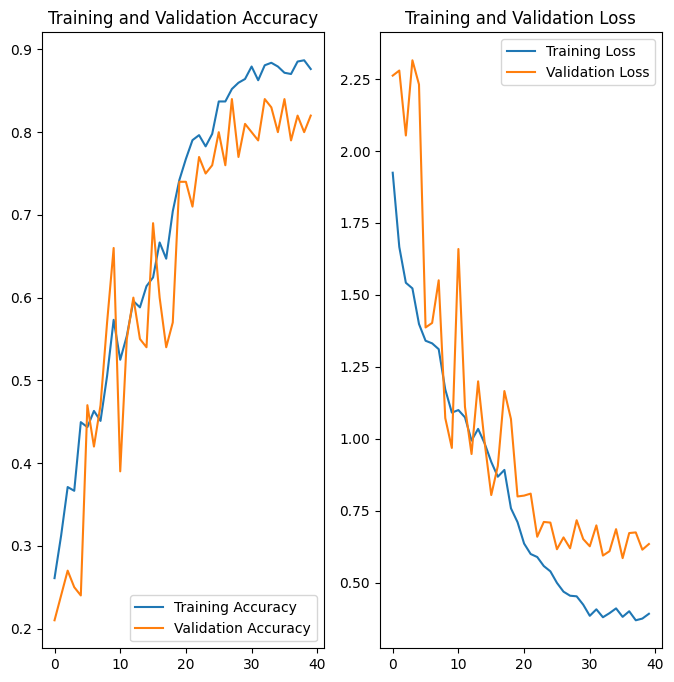

In [82]:
plot_acc(model_15,num_epochs)

#### **Observations**


By far the best performance thus far.
After looking into how to add skip connections to models, I saw that keras.layers.Sequential was actually quite limiting so I opted for the above method of model building which allows for greater flexibility.

There is very little overfitting with training acccuracies in the mid 80s and validation in the low 80s. The changes made from previous models were
- adding two more conv layers in order to learn more features as a deeper network should learn more than a shallow one.
- implementing skip connections which can help in the back prop of errors.
- more GRU cells to attempt to learn more temporal information.

### TRANSFER LEARNING MODELS

#### Model 16 - Transfer learning ResNet50

Constants
-

### RNN Model 4 - transfer learning EfficientNetB3

In [ ]:
from keras.applications import EfficientNetB3

#fewer parameters than others. will compare to other models with more params

efficientnet = EfficientNetB3(weights='imagenet', include_top=False, pooling='max')

efficientnet.trainable = True

43941136/43941136 [==============================] - 1s 0us/step


In [ ]:
!pip install tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 35.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server

In [ ]:
gru_cnn_2 = Sequential()

gru_cnn_2.add(TimeDistributed(efficientnet, input_shape=(30, 120, 120, 3))

gru_cnn_2.add(GRU(64))
gru_cnn_2.add(Dropout(0.3))

gru_cnn_2.add(Dense(5, activation='softmax'))

SyntaxError: invalid syntax (2470976064.py, line 5)

In [ ]:
optimiser = optimizers.Adam()
gru_cnn_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(gru_cnn_2.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'gesture_model_gru_2_' + str(curr_dt_time).replace('-','')

if not os.path.exists(model_name):

    os.mkdir(model_name)

filepath = model_name +"/" + model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = 'val_loss',
                      factor=0.3,
                      patience=2,
                      verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
gru_model_2 = gru_cnn_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)